Todo list:
    - describe difference between linearSVM and SVM with linear kernel.
    - document everything

# License plate OCR
Here text recognition is applied to licenseplates to retrieve the plate number.

## To start: dependancies 
This are the dependencies that are used.

* Cv2 is used to load and alter the image becaure the machine learning.
* Panda is used to create the dataframes in wich the data is contained.
* Random is used to shuffle the images.
* Os is used for system opperations as retrieving file or path names.
* Np is used for some arrays.
* Path is used to combine paths.
* sklearn is used for the machine learning.
* Plt is used to plot images.
* Threshold_otsu is a filter applied to the images.
* joblib is used to save the generated model.


In [1]:
import cv2; print('opencv version:', cv2.__version__)
import pandas as pd; print('panda version: ', pd.__version__)
import random;
from random import randint;
import os; 
import numpy as np;
from pathlib import Path
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt; 
from skimage.filters import threshold_otsu
import joblib
print(os.getcwd())

base_dir = os.getcwd()


opencv version: 3.4.2
panda version:  0.23.4
C:\Users\Rafal\Notebooks\Assignment6


## Setup the Datafetching
The data used will be gathered from the filesystem, The data consists of car and plate images (2 differen images) in a map named after the licenseplate.

Firstly, all these names are alphebeticly sorted in a list and then sorted with a preset seed to keep the training data as constant as possible. 

Then its checked if all the data is present. The scraper used wasnt able to get all the images and there where a few missing images, this check will filter those out.

In [2]:
dirs_data = []

text = sorted(os.listdir(base_dir + '/data'))
random.seed(448)
random.shuffle(text)

for item in text:
    dirs_data.append([base_dir + '/data/' + item + '/plate.png',
                     base_dir + '/data/' + item + '/car.jpg',
                     item])
    my_file = Path(base_dir + '/data/' + item + '/plate.png')
    if not my_file.is_file():
        print("Error: " + item)
    my_file = Path(base_dir + '/data/' + item + '/car.jpg') 
    if not my_file.is_file():
        print("Error: " + item)

## Loading...
When the data is known the images are loaded into the program. Here only the plate images are used to increase learning speed and reduce memory usage.

There are several sizes of plates available, for example the wide plates found on most cars and the taller but less wide plates found on motorcycles, and the machine learning algorithme can only handle 1 size. Rescaling is not an option because the dimensions are too different and would add too much distortion to the images, so the odd plates are filterd out. Every plate that has the correct size is resized to half its size to reduce the amount of learning time by roughly 75%. Plates starting with a 'U' are also not used because of its low occurence.

The letters of the plate are seperated to train with each of them. This will be done seperatly because there wouldn't be enough examples of eache plate to train the algorithm. But when seperating the letter it will train for each letter seperatly and thus have more samples from the same letter.


In [3]:
nPlates = 7000
nPlatesCount = 0
addedText = []
plateImg = []
binary = []

for _dir, _car, _text in dirs_data[0:nPlates:1]:
    img = cv2.imread(_dir,cv2.IMREAD_COLOR)
    height, width, channels = img.shape
    if(height == 50 and width == 235 and _text[0] != 'U'):
        nPlatesCount+=1
        addedText.append(_text)
        resizedImg = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
        plateImg.append(cv2.cvtColor(resizedImg,cv2.COLOR_BGR2GRAY))
        binary.append([])
        
text = addedText
nPlates = nPlatesCount
testData = pd.DataFrame(
    {
        "text": addedText,
        "plate": plateImg,
        "plate_binary": binary
    }
)
testData.reset_index(drop=True, inplace=True)

the images are now loaded.
Here a quick peek is given into the plates found in the list.

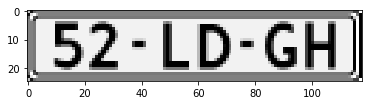

In [4]:
plt.imshow(testData.plate[9], cmap='gray')

Convert the pictures to a binary black and white and reshape them to be 1 layer thick arrays. This is because our OCR doesn't need to work with colors.

In [5]:
for i in range(nPlatesCount):
    img_details = plateImg[i] < threshold_otsu(plateImg[i])
    testData.plate_binary[i] = img_details.reshape(-1)

Only 1 letter is thought to the machine at a time. Because all the plates used are unique, it's not possible to train the algorithm with the whole plate. But most letters are used more ofthen then once, therefore it's better to train each letter individually. 

In [6]:
image_data, target_data = testData.plate_binary, testData.text
target_data_only_first = []

for x in target_data:
    target_data_only_first.append(x[0]);

target_data = target_data_only_first

unique_elements, counts_elements = np.unique(target_data, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))


Frequency of unique values of the said array:
[['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
  'J' 'K' 'L' 'M' 'N' 'O' 'P' 'R' 'S' 'T' 'V' 'W' 'X' 'Y' 'Z']
 ['227' '334' '321' '309' '313' '327' '318' '335' '334' '347' '265' '329'
  '32' '219' '6' '38' '131' '136' '143' '111' '47' '6' '162' '541' '160'
  '182' '139' '120' '225' '69' '75' '19' '64']]


Finnally the data is complete. The training can begin. 

For this, a LinearSVC is chosen, a normal SVC with a linear kernal has been tried, but the LinearSVC proved to be a lot faster and diliver improved results (93% accuracy vs 98%). The L1 penalty is used because there is no missing data in the dataset. Dual is false for optimalization because the data is bigger then the amount of features. the Tollerance of stopping criteria (tol) is set to 1e-3, this determains the accuracy of the learning and thus the fitment and time. higher value is more detailed fitment but also longer learning time. 

After the training is done, it is validated and prepared. Then the model is fitted (the actual training).

In [31]:
def cross_validation(model, num_of_fold, train_data, train_label):
    # this uses the concept of cross validation to measure the accuracy
    # of a model, the num_of_fold determines the type of validation
    # e.g if num_of_fold is 4, then we are performing a 4-fold cross validation
    # it will divide the dataset into 4 and use 1/4 of it for testing
    # and the remaining 3/4 for the training
    accuracy_result = cross_val_score(model, train_data, train_label,
                                      cv=num_of_fold)
    print("Cross Validation Result for ", str(num_of_fold), " -fold")

    print(accuracy_result * 100)

clf = svm.LinearSVC(penalty='l1', 
                    loss='squared_hinge', 
                    dual=False,
                    tol=1e-3)

cross_validation(clf, 4, image_data, target_data)
clf.fit(image_data, target_data)


Cross Validation Result for  4  -fold
[98.07333748 97.56402249 97.92843691 97.78621126]


LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0)

Then the model is saved for later use. 

In [32]:
joblib.dump(clf, base_dir + "/models/model-l1.svm")

['/home/bas/gitRepos/ES71-ComputerVision/Assignment6/models/model-l1.svm']

In map Assignment6/Threading are the previous steps repeated 9 times, one time for each letter and one time to test the whole plate at once. These can be started up seperatly and then loaded into this notebook. Each letter should be done quickly, and with the manual threading utilized it should be done withing 10 - 30 minutes. Learning the whole plate does take a lot longer. 

t0 - t7 contains each letter algorithm 

ta      contains the full plate algorithm 


In [14]:
clf = [
    joblib.load(base_dir + "/models/model-l1-t0.svm"),
    joblib.load(base_dir + "/models/model-l1-t1.svm"),
    joblib.load(base_dir + "/models/model-l1-t2.svm"),
    joblib.load(base_dir + "/models/model-l1-t3.svm"),
    joblib.load(base_dir + "/models/model-l1-t4.svm"),
    joblib.load(base_dir + "/models/model-l1-t5.svm"),
    joblib.load(base_dir + "/models/model-l1-t6.svm"),
    joblib.load(base_dir + "/models/model-l1-t7.svm"),
    joblib.load(base_dir + "/models/model-l1-ta.svm"),
]

When the new algorithms are loaded in they can be used to read a plate.
This will put use our two results, one with the 8 letters detected individually and one with the full plate trained (instead of 8 trainings with one character). 

['R']['B']['-']['6']['4']['6']['-']['X']
['SV-HB-26']


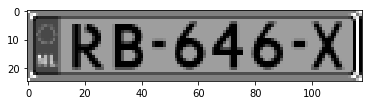

In [16]:
untrained_dirs_data = []

untrained_text = sorted(os.listdir(base_dir + '/data_untrained'))

for item in untrained_text:
    untrained_dirs_data.append([base_dir + '/data_untrained/' + item + '/plate.png',
                     base_dir + '/data_untrained/' + item + '/car.jpg',
                     item])
    my_file = Path(base_dir + '/data_untrained/' + item + '/plate.png')
    if not my_file.is_file():
        print("Error: " + item)
    my_file = Path(base_dir + '/data_untrained/' + item + '/car.jpg') 
    if not my_file.is_file():
        print("Error: " + item)

untrained_nPlates = 1
untrained_nPlatesCount = 0
untrained_addedText = []
untrained_plateImg = []
untrained_binary = []

for _dir, _car, _text in untrained_dirs_data:
    img = cv2.imread(_dir,cv2.IMREAD_COLOR)
    height, width, channels = img.shape
    if(height == 50 and width == 235):    
        untrained_nPlatesCount+=1
        untrained_addedText.append(_text)
        resizedImg = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
        untrained_plateImg.append(cv2.cvtColor(resizedImg,cv2.COLOR_BGR2GRAY))
        untrained_binary.append([])
        
untrained_text = untrained_addedText
untrained_nPlates = untrained_nPlatesCount
untrained_testData = pd.DataFrame(
    {
        "text": untrained_addedText,
        "plate": untrained_plateImg,
        "plate_binary": untrained_binary
    }
)

untrained_testData.reset_index(drop=True, inplace=True)

for i in range(untrained_nPlatesCount):
    untrained_img_details = untrained_plateImg[i] < threshold_otsu(untrained_plateImg[i])
    untrained_testData.plate_binary[i] = untrained_img_details.reshape(1,-1)
    
image_to_predict = 2

plt.imshow(untrained_testData.plate[image_to_predict], cmap='gray')
plate = ""

for i in range(8):
    plate += str(clf[i].predict(untrained_testData.plate_binary[image_to_predict].reshape(1,-1)))
print(plate)

print(str(clf[8].predict(untrained_testData.plate_binary[image_to_predict].reshape(1,-1))))

The result is the plate number as text from an input image.

This output is very accurate when the individual letters are detected and a plate from the same source (but not the same set) as the learning data is used. When a real plate is cut out and transformed to the same shape it still doesn't work properly. This is because the spacing and letters type are slightly different, which means the training data isn't diverse enough. 

When detecting the plate number in one go it will fail (using the algorithm trained on full plate at once). This is because the training cannot be propperly done as each plate has only 1 data value and will only appear once. So the algorithm is guessing one of the data values.
